In [ ]:
from typing import TypedDict, Annotated, Sequence
import operator
import json
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, FunctionMessage
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_community.tools.openweathermap import OpenWeatherMapQueryRun
from langgraph.prebuilt import ToolInvocation
from langgraph.prebuilt import ToolExecutor
from langgraph.graph import StateGraph, END

# Define the AgentState using TypedDict
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

# Bind the OpenWeatherMap tool
tools = [OpenWeatherMapQueryRun()]

# Initialize the ChatOpenAI model
model = ChatOpenAI(temperature=0, streaming=True)
functions = [convert_to_openai_function(t) for t in tools]
model = model.bind_functions(functions)


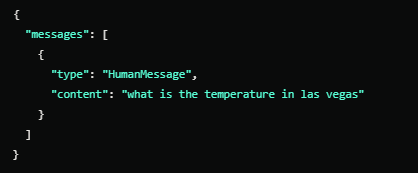

In [ ]:
# Function to handle LLM responses
def function_1(state):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}

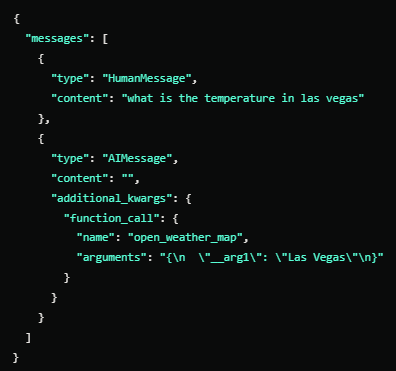

In [ ]:
# Function to determine next steps in the conversation
def where_to_go(state):
    messages = state['messages']
    last_message = messages[-1]
    
    if "function_call" in last_message.additional_kwargs:
        return "continue"
    else:
        return "end"

In [ ]:
# Set up ToolExecutor for invoking tools
tool_executor = ToolExecutor(tools)

# Function to handle tool invocation
def function_2(state):
    messages = state['messages']
    last_message = messages[-1]  # Get the last user message

    parsed_tool_input = json.loads(last_message.additional_kwargs["function_call"]["arguments"])

    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=parsed_tool_input['__arg1'],
    )

    response = tool_executor.invoke(action)

    # Assume the response is structured correctly to be used here
    function_message = FunctionMessage(content=str(response), name=action.tool)
    return {"messages": [function_message]}



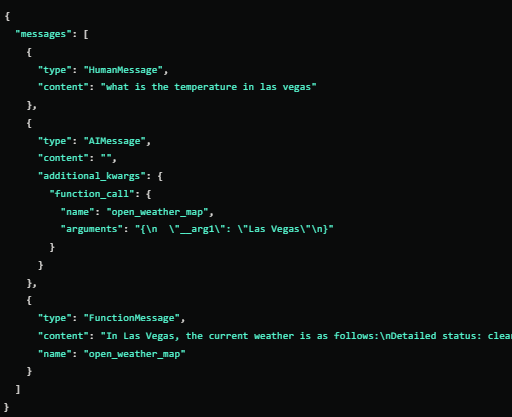

In [ ]:
# Set up the workflow graph
workflow = StateGraph(AgentState)

# Add nodes for agent and tool functions
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)

# Add conditional edges based on where_to_go function
workflow.add_conditional_edges("agent", where_to_go, {
    "continue": "tool",
    "end": END
})

# Add edge from tool back to agent
workflow.add_edge('tool', 'agent')

# Set the entry point to the agent
workflow.set_entry_point("agent")

# Compile the application
app = workflow.compile()



In [ ]:
# Example invocation of the application with user input
inputs = {"messages": [HumanMessage(content="what is the temperature in las vegas")]}

# Invoke the application
output = app.invoke(inputs)

# Print the output from the invocation
print(output)



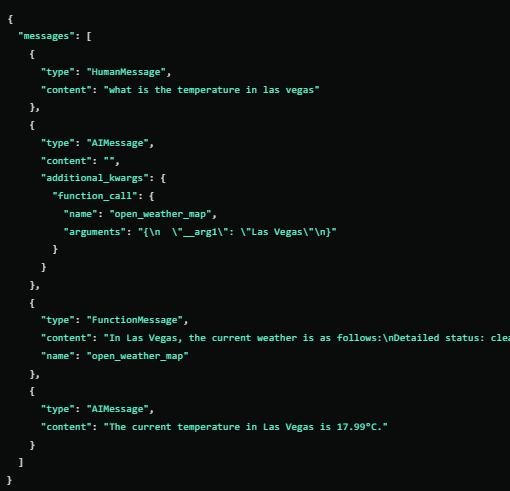

In [ ]:
inputs = {"messages": [HumanMessage(content="what is the temperature in las vegas")]}
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

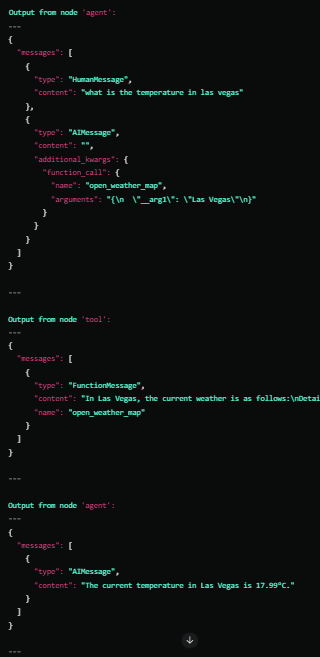